<font color = blue><font size = 6> 모델설명 </font></font><br>
이전에 activation을 추가한 모델에서 마지막 score x output 값들을 합치는 과정에서 Linear layer를 추가해서 가중합을 해준다

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [29]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [30]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [31]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/online-learning-DLinear']

In [32]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [33]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [34]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        self.activation = nn.Tanh()
        
        if self.individual==True: # 특성 각각에 별도의 layer를 두자고 하면 -> Layer를 담아놓을 list가 필요함
            self.Linear_Seasonal = nn.ModuleList() # 모듈을 담아놓는 리스트 파이썬의 리스트처럼 인덱스로 접근 가능하다
            self.Linear_Trend = nn.ModuleList()
            self.Linear_plus = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_plus.append(nn.Linear(2,1))
        else: # 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        
        # x의 size는 [Batch, Input_length, Channel]
        div_factor = x.permute(0,2,1)[:,-1,:].view(-1,1,1)
        x = x/div_factor
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.to(self.device) 
        # batch,input_size, sequence_length ex> tensor([[[1.6667, 2.0000, 2.6667, 3.6667],[1.6667, 2.0000, 2.6667, 3.6667]]])
        
        if self.individual==True:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],
                                              dtype = seasonal_init.dtype).to(seasonal_init.device)
                # seasonal_output을 저장할 Tensor를 만듦 Tip> ones도 비슷함
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),
                                            self.pred_len],dtype = trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):# feature의 갯수만큼 for문을 돌림 feature 각각에 대해서 linear layer에 투입
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                    # 위에서 seasonal init을 batch, input_size, sequence length로 바꿈 여기서 input size가 의미하는 바가 사실 
                    # feature의 갯수임 -> 따라서 각 피처마다 Linear Layer가 따로 있고 하나의 피처의 sequence length만큼의 데이터를 집어넣은후 학습하는 구조
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
                new_input = torch.cat([seasonal_output,trend_output],dim=1).view(-1,self.channels,2)
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)    
            trend_output = self.Linear_Trend(trend_init)
            seasonal_score,trend_score = self.activation(seasonal_output),self.activation(trend_output)
            
            new_input = torch.cat([seasonal_output*seasonal_score,trend_output*trend_score],dim=1).view(-1,1,2)
        x = self.Linear_plus(new_input)
        x = x*div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [35]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [36]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [37]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),6*1e-8)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

<font color =blue> zero_grad()의 이해 </font><br>
parameter들을 업데이트하는데,
한 루프에서 업데이트를 위해 loss.backward()를 호출하면 각 파라미터들의 .grad 값에 변화도가 저장이 된다.

이후 다음 루프에서 zero_grad()를 하지않고 역전파를 시키면 이전 루프에서 .grad에 저장된 값이 다음 루프의 업데이트에도 간섭을 해서 원하는 방향으로 학습이 안된다고 한다.

In [38]:
torch.manual_seed(42)

In [39]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [40]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
 
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 149.4820890231439 %
smape 144.36055520821733 %
smape 135.84704130016573 %
smape 125.58815507163779 %
smape 114.58666462647287 %
smape 103.42249645824322 %
smape 92.4320151791935 %
smape 81.80198892515305 %
smape 71.6373218081848 %
smape 61.992985574822676 %
smape 52.879803368919774 %
smape 44.295814448629905 %
smape 36.2508975100099 %
smape 28.703672910294337 %
smape 21.615071582515338 %
smape 14.958831384690882 %
smape 8.709084804643664 %
smape 2.8777751785056935 %
smape 0.6116455717064027 %
smape 0.6114952321019982 %
smape 0.6117953949680072 %
smape 0.6117942162798935 %
smape 0.6117169253224485 %
smape 0.6116004857848731 %
smape 0.611469354163937 %
smape 0.611330667923869 %
smape 0.611186286271822 %
smape 0.611046416183242 %
smape 0.6109031612000412 %
smape 0.6107587216228617 %
smape 0.6106069562609487 %
smape 0.610467969070254 %
smape 0.6103258939461281 %
smape 0.6101835059677387 %
smape 0.6100358299867451 %
smape 0.6098981542248628 %
smape 0.6097561308068403 %
smape 0.6096099

In [41]:
torch.manual_seed(42)

In [42]:
torch.arange(3*4)#np.arange()와 같은기능
A=torch.arange(3*4).view(1,1,-1).to(device)
print(A)
print(A[:,:,1:])
B=A[:,:,1:]
torch.cat([A,B],dim=2)

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')
tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]], device='cuda:0')


tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1,  2,  3,  4,  5,
           6,  7,  8,  9, 10, 11]]], device='cuda:0')

In [43]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
PATH = './my/Online_Dlearning_Path'
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)
torch.save(model,PATH+'/best_mymodel.pt') #모델의 갱신

SMAPE 0.12319903525826705 %
SMAPE 0.003810791870421326 %
SMAPE 0.006097762893197967 %
SMAPE 0.0004899403280944625 %
SMAPE 0.003996554297401644 %
SMAPE 0.003634668965176502 %
SMAPE 0.0008924450164613517 %
SMAPE 0.001802676786212487 %
SMAPE 0.002256800656368796 %
SMAPE 0.001258012549300247 %
SMAPE 0.00547378445541824 %
SMAPE 0.009195184248909527 %
SMAPE 0.0006612326437789307 %
SMAPE 0.0030053994867671463 %
SMAPE 0.0038376040526770794 %
SMAPE 0.011114017973653745 %
SMAPE 0.00455954465704167 %
SMAPE 0.004116685260733277 %
SMAPE 0.0024652779195690755 %
SMAPE 0.0018699396888166577 %
SMAPE 0.005016156257127591 %
SMAPE 0.005863681244136387 %
SMAPE 0.013871749908453523 %
SMAPE 0.001107189071490211 %
SMAPE 0.002803464637068487 %
SMAPE 0.008745205662847866 %
SMAPE 0.0036519037012112676 %
SMAPE 0.008506809282103234 %
SMAPE 0.008602548521139397 %
SMAPE 0.009779696181794861 %
SMAPE 0.0037103912729961057 %
SMAPE 0.003080211620101636 %
SMAPE 0.001449885707302201 %
SMAPE 0.000879446562393582 %
SMAPE 0.

SMAPE 0.011049917011945354 %
SMAPE 0.006396721497623048 %
SMAPE 0.017117749415717753 %
SMAPE 0.004177103812594396 %
SMAPE 0.009454588894584504 %
SMAPE 0.008211682153728361 %
SMAPE 0.029894511090446944 %
SMAPE 0.021012642714339336 %
SMAPE 0.027912771068365316 %
SMAPE 0.0015232739094415138 %
SMAPE 0.005000937776515002 %
SMAPE 0.010068209001474315 %
SMAPE 0.006419694948931466 %
SMAPE 0.007399511923900093 %
SMAPE 0.0026881739252928583 %
SMAPE 0.0027966109628323466 %
SMAPE 0.004927175988655108 %
SMAPE 0.004226080896359008 %
SMAPE 0.003056301070266443 %
SMAPE 0.00150481300465799 %
SMAPE 0.002240243389024954 %
SMAPE 0.0014588608101746559 %
SMAPE 0.0025721208776019466 %
SMAPE 0.0009934856779523216 %
SMAPE 0.0028766472636192475 %
SMAPE 0.0021201329237143796 %
SMAPE 0.003186583963781686 %
SMAPE 0.003761759875260395 %
SMAPE 0.0024441981353788833 %
SMAPE 0.009460280723416759 %
SMAPE 0.0043721897883415295 %
SMAPE 0.004033087005097968 %
SMAPE 0.004413666742607347 %
SMAPE 0.0036577271754083544 %
SMAP

SMAPE 0.011801629460620688 %
SMAPE 0.00222193140684368 %
SMAPE 0.007011339236441927 %
SMAPE 0.0040616060708202895 %
SMAPE 0.006704362598341618 %
SMAPE 0.0022464398904276095 %
SMAPE 0.0036553814526314454 %
SMAPE 0.0014508365038707893 %
SMAPE 0.0032084533987202235 %
SMAPE 0.009298268577367708 %
SMAPE 0.0015411922240673448 %
SMAPE 0.013866855252032908 %
SMAPE 0.0010964649240747804 %
SMAPE 0.001631678765249944 %
SMAPE 0.010157005695305088 %
SMAPE 0.0023575996877980288 %
SMAPE 0.02054164125976854 %
SMAPE 0.008149336455502976 %
SMAPE 0.004418380565141433 %
SMAPE 0.001493886020455193 %
SMAPE 0.0018964936098626595 %
SMAPE 0.008633178666855201 %
SMAPE 0.0006319768518281421 %
SMAPE 0.0019450482781735445 %
SMAPE 0.0023515171532153545 %
SMAPE 0.0009546404645774942 %
SMAPE 0.003787258370550717 %
SMAPE 0.006872995024878036 %
SMAPE 0.001513496923053026 %
SMAPE 0.0025944230242274102 %
SMAPE 0.0026763983692035254 %
SMAPE 0.00232616210115566 %
SMAPE 0.015886358505696307 %
SMAPE 0.0037271418847240056 %
S

SMAPE 0.007783332043871383 %
SMAPE 0.023386173470896665 %
SMAPE 0.003083186211767952 %
SMAPE 0.0006376821719698 %
SMAPE 0.007134141942024996 %
SMAPE 0.006403164138220063 %
SMAPE 0.016309210163399257 %
SMAPE 0.005949531588647972 %
SMAPE 0.007983084841313826 %
SMAPE 0.0008601009496658208 %
SMAPE 0.0016660802453429826 %
SMAPE 0.027304607539065273 %
SMAPE 0.017738239641175824 %
SMAPE 0.008093916656306988 %
SMAPE 0.0018924579387658012 %
SMAPE 0.00278252761963671 %
SMAPE 0.007187365012306657 %
SMAPE 0.006011541336988557 %
SMAPE 0.0043898017009667 %
SMAPE 0.0012572111184141477 %
SMAPE 0.0005673862376838201 %
SMAPE 0.010814532683042444 %
SMAPE 0.0014702835058528763 %
SMAPE 0.004293311699584024 %
SMAPE 0.0030513051283378445 %
SMAPE 0.0019300788923999335 %
SMAPE 0.004942388873097059 %
SMAPE 0.006103530200107343 %
SMAPE 0.0008979054210556115 %
SMAPE 0.008899495929597379 %
SMAPE 0.0031743647673465603 %
SMAPE 0.0026855966509060636 %
SMAPE 0.0029642689885349682 %
SMAPE 0.0011861061108646709 %
SMAPE 

SMAPE 0.0044632502846226885 %
SMAPE 0.046915036028281065 %
SMAPE 0.026510590783090038 %
SMAPE 0.008238123509613615 %
SMAPE 0.009089202855918188 %
SMAPE 0.004375786350948374 %
SMAPE 0.009315134590451635 %
SMAPE 0.0030189336722799 %
SMAPE 0.003968261024169806 %
SMAPE 0.0013017153828229766 %
SMAPE 0.0022684341864191992 %
SMAPE 0.0052819122643796845 %
SMAPE 0.006401547236492888 %
SMAPE 0.002941937984815013 %
SMAPE 0.003425482681763014 %
SMAPE 0.0014221155665552487 %
SMAPE 0.0026043036685905463 %
SMAPE 0.003532363580234232 %
SMAPE 0.00494175646616668 %
SMAPE 0.004582975568268921 %
SMAPE 0.016872539620607085 %
SMAPE 0.001123826259913585 %
SMAPE 0.001090002028604431 %
SMAPE 0.003945313230587999 %
SMAPE 0.007435111116876669 %
SMAPE 0.004851389173268217 %
SMAPE 0.0017922537567187646 %
SMAPE 0.008294404344454165 %
SMAPE 0.0040968287386533575 %
SMAPE 0.0009887221851272443 %
SMAPE 0.001712124171092455 %
SMAPE 0.0024248735061860316 %
SMAPE 0.002211487304748516 %
SMAPE 0.004145654296614509 %
SMAPE 0

SMAPE 0.0061280432164210205 %
SMAPE 0.006735613923240179 %
SMAPE 0.002241550120643865 %
SMAPE 0.0063995490463923934 %
SMAPE 0.007090678609969814 %
SMAPE 0.005979675872652024 %
SMAPE 0.0012814788865682658 %
SMAPE 0.003788634686543446 %
SMAPE 0.003727631108368712 %
SMAPE 0.0023266710329465923 %
SMAPE 0.0013421819037375826 %
SMAPE 0.001740698232325144 %
SMAPE 0.0016882344198876353 %
SMAPE 0.0025122777636852334 %
SMAPE 0.004063065368022478 %
SMAPE 0.011080448037034785 %
SMAPE 0.00647095052096347 %
SMAPE 0.002004156060763762 %
SMAPE 0.0018567616791926866 %
SMAPE 0.0072007302301884115 %
SMAPE 0.0064404509339510705 %
SMAPE 0.0021536328135880467 %
SMAPE 0.001261445788088622 %
SMAPE 0.010820834376929156 %
SMAPE 0.006482939785932729 %
SMAPE 0.0016114935691007304 %
SMAPE 0.010535403737094384 %
SMAPE 0.012242447802947256 %
SMAPE 0.003848456971525138 %
SMAPE 0.005601089980899587 %
SMAPE 0.0009800945075539857 %
SMAPE 0.0009663211296384588 %
SMAPE 0.000776892397254869 %
SMAPE 0.0028433458026313474 %


SMAPE 0.0016967833630872065 %
SMAPE 0.00426571454158875 %
SMAPE 0.004290190968333718 %
SMAPE 0.0022773101515838334 %
SMAPE 0.0011999381535048315 %
SMAPE 0.006538263640990748 %
SMAPE 0.004146920925904851 %
SMAPE 0.0026689975710070257 %
SMAPE 0.0077491170376333685 %
SMAPE 0.0038379801321752898 %
SMAPE 0.0035623616851410134 %
SMAPE 0.00437697277868665 %
SMAPE 0.003152742285521981 %
SMAPE 0.000885722917260523 %
SMAPE 0.0016888187735162317 %
SMAPE 0.005942945886857842 %
SMAPE 0.001981619856536554 %
SMAPE 0.002910778425814442 %
SMAPE 0.0022379084247106107 %
SMAPE 0.0015067570214810644 %
SMAPE 0.0070198883665781855 %
SMAPE 0.0017059019946259468 %
SMAPE 0.005641452497229693 %
SMAPE 0.0059763450432512855 %
SMAPE 0.0012873770206169866 %
SMAPE 0.010004148144332703 %
SMAPE 0.0026358470613701 %
SMAPE 0.0037563610551387687 %
SMAPE 0.003494702606019473 %
SMAPE 0.0010019731839747692 %
SMAPE 0.002676602183612431 %
SMAPE 0.003166017312246083 %
SMAPE 0.000728165410521342 %
SMAPE 0.0050651935943051285 %
S

SMAPE 0.0012652209656920377 %
SMAPE 0.0020844704787919 %
SMAPE 0.0015638696164046453 %
SMAPE 0.0029701595820768034 %
SMAPE 0.0021679648208419167 %
SMAPE 0.007292905786414394 %
SMAPE 0.001524993426698984 %
SMAPE 0.0033255917825272263 %
SMAPE 0.004030832527917028 %
SMAPE 0.008029148041515555 %
SMAPE 0.007865676409920752 %
SMAPE 0.004818107567530205 %
SMAPE 0.0020524823921732605 %
SMAPE 0.0031851961623203806 %
SMAPE 0.0006810584392837882 %
SMAPE 0.001477512775252876 %
SMAPE 0.0025142999656964093 %
SMAPE 0.0008433995594572252 %
SMAPE 0.007932915777033145 %
SMAPE 0.003730286838461438 %
SMAPE 0.0028446211855737147 %
SMAPE 0.016069382256716835 %
SMAPE 0.014596624577109196 %
SMAPE 0.00565564162113219 %
SMAPE 0.004479894562024356 %
SMAPE 0.00414787166437236 %
SMAPE 0.003185055156521344 %
SMAPE 0.0027073355867059945 %
SMAPE 0.012674406109567828 %
SMAPE 0.00376467801089575 %
SMAPE 0.0011080606514894953 %
SMAPE 0.003201236945187702 %
SMAPE 0.0034946853708532895 %
SMAPE 0.002490473395383219 %
SMAPE

SMAPE 0.0038679311824836304 %
SMAPE 0.0022004360028944348 %
SMAPE 0.0005646293654493206 %
SMAPE 0.002360221986123179 %
SMAPE 0.005150345669193257 %
SMAPE 0.0040767208923355724 %
SMAPE 0.004503437856044457 %
SMAPE 0.0019257889014809846 %
SMAPE 0.009324060700706127 %
SMAPE 0.004632859635165687 %
SMAPE 0.002603298504538998 %
SMAPE 0.0006093433247684743 %
SMAPE 0.006420881690516467 %
SMAPE 0.004644116976521673 %
SMAPE 0.0056252606472639854 %
SMAPE 0.0009089612862283046 %
SMAPE 0.0038931643953716843 %
SMAPE 0.0016076866709937576 %
SMAPE 0.008317773594967548 %
SMAPE 0.001552319527434065 %
SMAPE 0.0014836955955672693 %
SMAPE 0.002040869297438519 %
SMAPE 0.003913389423317426 %
SMAPE 0.0014688578624202364 %
SMAPE 0.0007832691154590067 %
SMAPE 0.0036900240152135666 %
SMAPE 0.0010746319896810519 %
SMAPE 0.007661465530105716 %
SMAPE 0.00451013529068689 %
SMAPE 0.0049188462111544595 %
SMAPE 0.006758245123364759 %
SMAPE 0.0077494888238760495 %
SMAPE 0.001981518952334227 %
SMAPE 0.0050746859982382375

SMAPE 0.0014037606342753861 %
SMAPE 0.002530646037087081 %
SMAPE 0.00536907296582001 %
SMAPE 0.003208131553577687 %
SMAPE 0.0038560970233518788 %
SMAPE 0.002286670479861641 %
SMAPE 0.006879517592551564 %
SMAPE 0.0027288861243448537 %
SMAPE 0.007988226736046045 %
SMAPE 0.008767533899288082 %
SMAPE 0.005293858150082542 %
SMAPE 0.001004168456731236 %
SMAPE 0.006474565384046116 %
SMAPE 0.0022274610080330604 %
SMAPE 0.0011012033057795634 %
SMAPE 0.0015107654796793213 %
SMAPE 0.003826045936932587 %
SMAPE 0.012175997562394514 %
SMAPE 0.007397815720537437 %
SMAPE 0.005903334028687368 %
SMAPE 0.0027754318682866597 %
SMAPE 0.008585027934941536 %
SMAPE 0.004567076735838782 %
SMAPE 0.00727383277794047 %
SMAPE 0.0029679055984956904 %
SMAPE 0.004039409286313855 %
SMAPE 0.013313466318578548 %
SMAPE 0.004076530366489806 %
SMAPE 0.0008971506564847687 %
SMAPE 0.004627020071708898 %
SMAPE 0.008386406079139874 %
SMAPE 0.0030297309552622664 %
SMAPE 0.0038083932568042655 %
SMAPE 0.0012929350545505258 %
SMAP

SMAPE 0.001104679448872048 %
SMAPE 0.0010327624520769518 %
SMAPE 0.0032594165833330635 %
SMAPE 0.0005468231556520209 %
SMAPE 0.0014038191403500377 %
SMAPE 0.002164903517957839 %
SMAPE 0.0054982091069746275 %
SMAPE 0.004935310459828202 %
SMAPE 0.002825616623482574 %
SMAPE 0.003525096152941387 %
SMAPE 0.0026441237527023986 %
SMAPE 0.009980187414498687 %
SMAPE 0.000719402861392382 %
SMAPE 0.01030059176036957 %
SMAPE 0.003889505799307358 %
SMAPE 0.0024394478380003193 %
SMAPE 0.0015760967946221174 %
SMAPE 0.0035382786318791663 %
SMAPE 0.005796770661618211 %
SMAPE 0.004406456698440309 %
SMAPE 0.0009984607633555243 %
SMAPE 0.0012609686368136863 %
SMAPE 0.00816034591594672 %
SMAPE 0.0020558358205846616 %
SMAPE 0.0042195852954876045 %
SMAPE 0.004835730755317513 %
SMAPE 0.0019072834127200622 %
SMAPE 0.004314164566089573 %
SMAPE 0.0016859144813281546 %
SMAPE 0.002038413824678287 %
SMAPE 0.004654161872963414 %
SMAPE 0.0026657252370796414 %
SMAPE 0.003615566257394675 %
SMAPE 0.0010173934626891423 %

SMAPE 0.011792781522899531 %
SMAPE 0.01844737274890207 %
SMAPE 0.00569583052561029 %
SMAPE 0.020829438081818807 %
SMAPE 0.0075476641908949205 %
SMAPE 0.028112320086734147 %
SMAPE 0.0031159574095056537 %
SMAPE 0.00710040677441981 %
SMAPE 0.010703041362262411 %
SMAPE 0.004844852566748159 %
SMAPE 0.0014526866527546645 %
SMAPE 0.006342642425011036 %
SMAPE 0.0034721408512154994 %
SMAPE 0.004184573130146418 %
SMAPE 0.002525670590102891 %
SMAPE 0.0026320612569747937 %
SMAPE 0.0038736901038021188 %
SMAPE 0.0032206264085345992 %
SMAPE 0.007538518991367482 %
SMAPE 0.0018222137495058632 %
SMAPE 0.008549047719810687 %
SMAPE 0.0019285761372529464 %
SMAPE 0.0016031011889481306 %
SMAPE 0.01422574183305869 %
SMAPE 0.006827243613770406 %
SMAPE 0.015068404214218845 %
SMAPE 0.0008284248348076062 %
SMAPE 0.004064756635017375 %
SMAPE 0.012566674480950724 %
SMAPE 0.0005308458121930926 %
SMAPE 0.009354252193162438 %
SMAPE 0.01255581759063773 %
SMAPE 0.0033542484056212634 %
SMAPE 0.013405002528280363 %
SMAPE 

SMAPE 0.010857651339676977 %
SMAPE 0.004795436209633408 %
SMAPE 0.0012831362647318656 %
SMAPE 0.002236759546697442 %
SMAPE 0.005213910151496748 %
SMAPE 0.0007010069319335344 %
SMAPE 0.00466638122219365 %
SMAPE 0.010415360283900554 %
SMAPE 0.002114665015000128 %
SMAPE 0.023647183383786796 %
SMAPE 0.00324023347637592 %
SMAPE 0.0031806724796155095 %
SMAPE 0.02508634859140102 %
SMAPE 0.004153433826445507 %
SMAPE 0.0012027163948289399 %
SMAPE 0.005886502901006452 %
SMAPE 0.0012947886795871 %
SMAPE 0.004993896839550871 %
SMAPE 0.012996760864780299 %
SMAPE 0.0044658047102075216 %
SMAPE 0.0023365794240817195 %
SMAPE 0.015721843899740406 %
SMAPE 0.0026564614460085068 %
SMAPE 0.00797938839014023 %
SMAPE 0.015910606528137805 %
SMAPE 0.01454868652597696 %
SMAPE 0.0047230275825995705 %
SMAPE 0.014360095130314221 %
SMAPE 0.007912901843212694 %
SMAPE 0.010725202767389419 %
SMAPE 0.009848200824990272 %
SMAPE 0.0013348733147608982 %
SMAPE 0.007922664627017184 %
SMAPE 0.009593655002277046 %
SMAPE 0.0023

SMAPE 0.0009348376011928393 %
SMAPE 0.009411464489176069 %
SMAPE 0.0038677947071903422 %
SMAPE 0.007176425815202947 %
SMAPE 0.0006908574246011767 %
SMAPE 0.0034853001598946776 %
SMAPE 0.0010076452776672795 %
SMAPE 0.002396269626174785 %
SMAPE 0.0007151121362269919 %
SMAPE 0.01725547468026889 %
SMAPE 0.003702141294013473 %
SMAPE 0.0005026212505754302 %
SMAPE 0.008385324185738341 %
SMAPE 0.0012326816239891514 %
SMAPE 0.004811532125586382 %
SMAPE 0.004947360614764307 %
SMAPE 0.0027892201726658072 %
SMAPE 0.0011405482687791846 %
SMAPE 0.0008746974121436324 %
SMAPE 0.01541252431466944 %
SMAPE 0.023126941425005043 %
SMAPE 0.0021032669563680884 %
SMAPE 0.01125006834558917 %
SMAPE 0.005897438439774305 %
SMAPE 0.017254914134973376 %
SMAPE 0.0008417365370689821 %
SMAPE 0.00716541878989574 %
SMAPE 0.007065572166538915 %
SMAPE 0.0060416993799208285 %
SMAPE 0.0017558366771481815 %
SMAPE 0.002226987422581317 %
SMAPE 0.012666366159464815 %
SMAPE 0.009212970595115166 %
SMAPE 0.0014781352791715108 %
SM

SMAPE 0.005071400409917715 %
SMAPE 0.013243207895584417 %
SMAPE 0.02356827390917715 %
SMAPE 0.013733100510791019 %
SMAPE 0.007545856720469147 %
SMAPE 0.009569413103804436 %
SMAPE 0.015449730537710591 %
SMAPE 0.006992896684096195 %
SMAPE 0.0008824559781857033 %
SMAPE 0.005271046334996754 %
SMAPE 0.0016435414264037718 %
SMAPE 0.009804431778519529 %
SMAPE 0.013494434483590112 %
SMAPE 0.0035700604504427247 %
SMAPE 0.004029631461833105 %
SMAPE 0.013410827374428889 %
SMAPE 0.001622135829862259 %
SMAPE 0.005211730702342265 %
SMAPE 0.001079840692000289 %
SMAPE 0.011130417957872396 %
SMAPE 0.005239942740558945 %
SMAPE 0.00110695864923116 %
SMAPE 0.0024383433219554718 %
SMAPE 0.0026383961769624875 %
SMAPE 0.01389498009044132 %
SMAPE 0.002239330610336765 %
SMAPE 0.021308003988167457 %
SMAPE 0.015384119823863784 %
SMAPE 0.00104459123815559 %
SMAPE 0.007514889658779111 %
SMAPE 0.003474339099511781 %
SMAPE 0.0027061754981190234 %
SMAPE 0.0011545161942478899 %
SMAPE 0.006596719219245983 %
SMAPE 0.004

SMAPE 0.006661878067120596 %
SMAPE 0.00415041214932188 %
SMAPE 0.013784688911911758 %
SMAPE 0.025375574393670774 %
SMAPE 0.00250954771504297 %
SMAPE 0.00969622094359579 %
SMAPE 0.006379411868067563 %
SMAPE 0.001140874084768484 %
SMAPE 0.0017719698149676333 %
SMAPE 0.010736863744682523 %
SMAPE 0.016943637867029793 %
SMAPE 0.0032770646251947255 %
SMAPE 0.004185468231014511 %
SMAPE 0.019523013969262593 %
SMAPE 0.0010367663042814002 %
SMAPE 0.008753589117077354 %
SMAPE 0.014385781238246409 %
SMAPE 0.02063059413534063 %
SMAPE 0.0010988091503350006 %
SMAPE 0.0049030395223326195 %
SMAPE 0.0043172036762371135 %
SMAPE 0.004349624994418377 %
SMAPE 0.004235520407462445 %
SMAPE 0.015297102013803965 %
SMAPE 0.00500082798873791 %
SMAPE 0.000865028632404119 %
SMAPE 0.0012501576998147357 %
SMAPE 0.0044179734954283845 %
SMAPE 0.0014184722568870711 %
SMAPE 0.0022184637396520657 %
SMAPE 0.005445689639529405 %
SMAPE 0.0034227518214464685 %
SMAPE 0.003868853917126103 %
SMAPE 0.00795508308965509 %
SMAPE 0.0

SMAPE 0.02060113349449466 %
SMAPE 0.028328913295950997 %
SMAPE 0.031187276028191487 %
SMAPE 0.0008567273291930634 %
SMAPE 0.0010366624035214045 %
SMAPE 0.0029256538200286286 %
SMAPE 0.0053817352336409385 %
SMAPE 0.005417935201109003 %
SMAPE 0.003939310617624869 %
SMAPE 0.003447130346017957 %
SMAPE 0.005743766338952128 %
SMAPE 0.007266917384583849 %
SMAPE 0.007974766679211598 %
SMAPE 0.004481995419808982 %
SMAPE 0.005093978317518122 %
SMAPE 0.0022308450120362977 %
SMAPE 0.001306374724592274 %
SMAPE 0.00851744418972089 %
SMAPE 0.011316111082919633 %
SMAPE 0.02962687827016452 %
SMAPE 0.029324266329354032 %
SMAPE 0.021465120647462754 %
SMAPE 0.008083487829566138 %
SMAPE 0.006361614575666863 %
SMAPE 0.007703296761235379 %
SMAPE 0.008260755409764897 %
SMAPE 0.001502396558635155 %
SMAPE 0.009602326204685596 %
SMAPE 0.002207720752892328 %
SMAPE 0.0030605135482346672 %
SMAPE 0.005379565681550957 %
SMAPE 0.003405232418117521 %
SMAPE 0.0036143730850710654 %
SMAPE 0.003313226627533083 %
SMAPE 0.00

SMAPE 0.011425895500593697 %
SMAPE 0.0018380400904192127 %
SMAPE 0.01266554620100635 %
SMAPE 0.0038061964173721208 %
SMAPE 0.08586311019570303 %
SMAPE 0.006111297040206409 %
SMAPE 0.009031249849854817 %
SMAPE 0.01166717232465686 %
SMAPE 0.0019141670043438808 %
SMAPE 0.002500506464102159 %
SMAPE 0.17849402692399963 %
SMAPE 0.007567441105820194 %
SMAPE 0.02571395945346921 %
SMAPE 0.015421267968633854 %
SMAPE 0.012500644219016978 %
SMAPE 0.030487384057920508 %
SMAPE 0.1432524987166346 %
SMAPE 0.009037629574521588 %
SMAPE 0.028021023002054335 %
SMAPE 0.0040543313359791 %
SMAPE 0.005180233630710518 %
SMAPE 0.036802420294520743 %
SMAPE 0.1170194092612462 %
SMAPE 0.07367872668066866 %
SMAPE 0.0030373765724220902 %
SMAPE 0.03161937719923458 %
SMAPE 0.0008029568475933503 %
SMAPE 0.025587609072772462 %
SMAPE 0.003940997114199263 %
SMAPE 0.01863352936834417 %
SMAPE 0.0009998604984957637 %
SMAPE 0.0006395555981981715 %
SMAPE 0.013318419802672567 %
SMAPE 0.09015312433382405 %
SMAPE 0.00648890146641

SMAPE 0.29612687082772027 %
SMAPE 0.0045816055319392035 %
SMAPE 0.15946987167262705 %
SMAPE 1.453611459583044 %
SMAPE 0.1716955840911396 %
SMAPE 0.4300630202051252 %
SMAPE 0.8169742138125001 %
SMAPE 0.0367134987091049 %
SMAPE 0.4434896957827732 %
SMAPE 0.005945399043412181 %
SMAPE 0.0799117680498398 %
SMAPE 0.14946433826389693 %
SMAPE 0.14891317781962243 %
SMAPE 0.03432503806288878 %
SMAPE 0.5425637601874769 %
SMAPE 0.0583203004216557 %
SMAPE 0.31440949270836427 %
SMAPE 1.471338851377368 %
SMAPE 0.24362967992010454 %
SMAPE 0.06867872687053023 %
SMAPE 0.005761868658851199 %
SMAPE 0.3273393507442961 %
SMAPE 0.8545440989546478 %
SMAPE 1.0953194838948548 %
SMAPE 0.10031973836476028 %
SMAPE 0.14236141932587998 %
SMAPE 0.3662621814291924 %
SMAPE 0.0027417994251663913 %
SMAPE 0.23407434895398183 %
SMAPE 0.14261326734026625 %
SMAPE 0.31900271792801504 %
SMAPE 0.04277382556506382 %
SMAPE 0.02313933425648429 %
SMAPE 0.09379309654266876 %
SMAPE 0.015773192063534225 %
SMAPE 0.22241307547710676 %
S

SMAPE 0.0022390016291069514 %
SMAPE 0.001525090608296864 %
SMAPE 0.018544583471907572 %
SMAPE 0.01442318056149361 %
SMAPE 0.011327976266557016 %
SMAPE 0.0006922314633897031 %
SMAPE 0.0020897029337447748 %
SMAPE 0.0010748964440026043 %
SMAPE 0.007361374500192142 %
SMAPE 0.0034165383558928397 %
SMAPE 0.003045042289613775 %
SMAPE 0.017337735321248715 %
SMAPE 0.0005189365031412763 %
SMAPE 0.006633400117848964 %
SMAPE 0.006134016013447763 %
SMAPE 0.0057065789258103905 %
SMAPE 0.002907818519133798 %
SMAPE 0.01689077409980655 %
SMAPE 0.03003905818869157 %
SMAPE 0.0027045662034765883 %
SMAPE 0.0021585087254862856 %
SMAPE 0.04073545190283312 %
SMAPE 0.015154309949778623 %
SMAPE 0.011344814000153747 %
SMAPE 0.015525803858992049 %
SMAPE 0.010319549961536723 %
SMAPE 0.01826467723242331 %
SMAPE 0.010139961399630693 %
SMAPE 0.002519444280643768 %
SMAPE 0.01485696732629549 %
SMAPE 0.006195768904305509 %
SMAPE 0.010240413700785211 %
SMAPE 0.0022408740516937087 %
SMAPE 0.003556300902516796 %
SMAPE 0.00

SMAPE 0.009874349112237724 %
SMAPE 0.0006807081485717958 %
SMAPE 0.008562467355659464 %
SMAPE 0.01582779353434205 %
SMAPE 0.0023265615673011553 %
SMAPE 0.004249565703872804 %
SMAPE 0.009457619408010487 %
SMAPE 0.010563544779529366 %
SMAPE 0.005902813228573223 %
SMAPE 0.0017330939316479996 %
SMAPE 0.008102545153747087 %
SMAPE 0.005276033903669486 %
SMAPE 0.009231927684879793 %
SMAPE 0.010713890679937776 %
SMAPE 0.0019919315723484488 %
SMAPE 0.008622696931439577 %
SMAPE 0.008513853103863767 %
SMAPE 0.04569121071767768 %
SMAPE 0.016514197969399902 %
SMAPE 0.04074013757648487 %
SMAPE 0.005225344606259341 %
SMAPE 0.0025995659651982805 %
SMAPE 0.018512401401238776 %
SMAPE 0.010907588537008905 %
SMAPE 0.019916349680968892 %
SMAPE 0.037329914801830455 %
SMAPE 0.011861162074566778 %
SMAPE 0.004375902218129113 %
SMAPE 0.003947386058307245 %
SMAPE 0.0020114422194694725 %
SMAPE 0.0040846439126198675 %
SMAPE 0.004175090130971171 %
SMAPE 0.016915495655261736 %
SMAPE 0.003107911008541464 %
SMAPE 0.00

SMAPE 0.005299865102678325 %
SMAPE 0.007199898338683397 %
SMAPE 0.004570051633820071 %
SMAPE 0.01142023889894972 %
SMAPE 0.00599338092627022 %
SMAPE 0.0039806851971206925 %
SMAPE 0.020597661914735 %
SMAPE 0.014478597651859104 %
SMAPE 0.0013766508500339114 %
SMAPE 0.015607506980131802 %
SMAPE 0.0033045515977647715 %
SMAPE 0.00844904661435919 %
SMAPE 0.0016591120529483307 %
SMAPE 0.000936870165098469 %
SMAPE 0.001479142817771617 %
SMAPE 0.015311919459009003 %
SMAPE 0.004132853516885859 %
SMAPE 0.010725672799409836 %
SMAPE 0.0021427305876215996 %
SMAPE 0.004793470990620108 %
SMAPE 0.0035563782971763653 %
SMAPE 0.0009703333962534089 %
SMAPE 0.008861737000714243 %
SMAPE 0.011062139643158275 %
SMAPE 0.012071530643787298 %
SMAPE 0.0035015208573980767 %
SMAPE 0.0057424825552629954 %
SMAPE 0.02942381685488726 %
SMAPE 0.001609964073061576 %
SMAPE 0.012239096285497906 %
SMAPE 0.007114597754210195 %
SMAPE 0.0034762890931574475 %
SMAPE 0.024196138386813004 %
SMAPE 0.0007733875922184552 %
SMAPE 0.00

SMAPE 0.004421201973720201 %
SMAPE 0.014209272625279823 %
SMAPE 0.021045448559675606 %
SMAPE 0.004969709727902227 %
SMAPE 0.01183848125822351 %
SMAPE 0.012100458806656889 %
SMAPE 0.005341999670321229 %
SMAPE 0.005510112335130657 %
SMAPE 0.0094750855099619 %
SMAPE 0.0038494451152928377 %
SMAPE 0.0135557767110015 %
SMAPE 0.0031655001591843757 %
SMAPE 0.019548141129718033 %
SMAPE 0.002612352171894372 %
SMAPE 0.006917346750128671 %
SMAPE 0.0023848536330888237 %
SMAPE 0.0031010990005597705 %
SMAPE 0.002788136137382935 %
SMAPE 0.02703974572460766 %
SMAPE 0.009456742567827803 %
SMAPE 0.0301012057611274 %
SMAPE 0.006981096655124475 %
SMAPE 0.0006578223226370028 %
SMAPE 0.05709207492125756 %
SMAPE 0.035136537364110154 %
SMAPE 0.02926677784671483 %
SMAPE 0.052783270588406594 %
SMAPE 0.01421526114648941 %
SMAPE 0.003518572175465806 %
SMAPE 0.059347391078972585 %
SMAPE 0.007620270863604617 %
SMAPE 0.028126372972792524 %
SMAPE 0.02142599479600449 %
SMAPE 0.005258877975059306 %
SMAPE 0.0033393137094

SMAPE 0.01111477447731346 %
SMAPE 0.011909630583147646 %
SMAPE 0.005593164560508512 %
SMAPE 0.0009146613345123457 %
SMAPE 0.5770004228688776 %
SMAPE 0.02328644714532402 %
SMAPE 0.029973820685469832 %
SMAPE 0.048969261067867365 %
SMAPE 0.05819743415304402 %
SMAPE 0.01741514832386315 %
SMAPE 0.07054502246228367 %
SMAPE 0.05852614740103945 %
SMAPE 0.1810218836662898 %
SMAPE 0.013486077144790444 %
SMAPE 0.006580760154008658 %
SMAPE 0.005637213000795782 %
SMAPE 0.0017183767180597442 %
SMAPE 0.019972269564561884 %
SMAPE 0.004124740656038739 %
SMAPE 0.0011777768811214173 %
SMAPE 0.010858774597579668 %
SMAPE 0.012037160480417697 %
SMAPE 0.010501049404105345 %
SMAPE 0.006680318085727777 %
SMAPE 0.019251459695624362 %
SMAPE 0.010874126319947663 %
SMAPE 0.011117552874225112 %
SMAPE 0.01850559159944254 %
SMAPE 0.002874029496467756 %
SMAPE 0.013123002135330354 %
SMAPE 0.011497191691105968 %
SMAPE 0.0018082448141143457 %
SMAPE 0.0068017185816415795 %
SMAPE 0.03189890223978864 %
SMAPE 0.0038111529245

SMAPE 0.006134617627722604 %
SMAPE 0.002209241278038121 %
SMAPE 0.005350215441211503 %
SMAPE 0.003140437961974385 %
SMAPE 0.0008924638754308489 %
SMAPE 0.01802821668411525 %
SMAPE 0.01041175249896753 %
SMAPE 0.0008466608461503711 %
SMAPE 0.0032694820434358007 %
SMAPE 0.01745722116476145 %
SMAPE 0.0017339313329216568 %
SMAPE 0.020304570754689166 %
SMAPE 0.010329211293765184 %
SMAPE 0.01239890127851595 %
SMAPE 0.01581126969426805 %
SMAPE 0.008291924728936806 %
SMAPE 0.018025525386747177 %
SMAPE 0.02245338170548905 %
SMAPE 0.0025072410955786495 %
SMAPE 0.003392852258457424 %
SMAPE 0.009463802021272727 %
SMAPE 0.0028523237887227992 %
SMAPE 0.004186427667661974 %
SMAPE 0.0034377089487946932 %
SMAPE 0.0007925739593588332 %
SMAPE 0.0026569930853526103 %
SMAPE 0.0028422527875591186 %
SMAPE 0.002307908193316166 %
SMAPE 0.006521921569856204 %
SMAPE 0.0007577756433008176 %
SMAPE 0.001823487269348334 %
SMAPE 0.0015413388057510249 %
SMAPE 0.007269610228632928 %
SMAPE 0.013202567098524298 %
SMAPE 0.

SMAPE 0.005116225277376429 %
SMAPE 0.011338034257434515 %
SMAPE 0.01310926487902009 %
SMAPE 0.01695488270316048 %
SMAPE 0.0014320729313226366 %
SMAPE 0.0007862432149181586 %
SMAPE 0.0058615487619562145 %
SMAPE 0.007379262249259 %
SMAPE 0.005017803257203468 %
SMAPE 0.002305210502854038 %
SMAPE 0.0012992293618765416 %
SMAPE 0.002306399568908546 %
SMAPE 0.0022882504676999815 %
SMAPE 0.006207348698808346 %
SMAPE 0.012200310651294899 %
SMAPE 0.013501857973409416 %
SMAPE 0.0022585130986954027 %
SMAPE 0.001834081759284345 %
SMAPE 0.03444175365592628 %
SMAPE 0.0016050016113240417 %
SMAPE 0.03840144792684441 %
SMAPE 0.020383443980392713 %
SMAPE 0.006749492167472226 %
SMAPE 0.002170925571533644 %
SMAPE 0.03290894792203858 %
SMAPE 0.005083758386319914 %
SMAPE 0.039287477392576875 %
SMAPE 0.021244235942788237 %
SMAPE 0.0259261181599868 %
SMAPE 0.03621313493926692 %
SMAPE 0.01870580900811092 %
SMAPE 0.02288940703715525 %
SMAPE 0.0091885184874414 %
SMAPE 0.0034660852313379564 %
SMAPE 0.0020781159883

SMAPE 0.003356277833887589 %
SMAPE 0.005530801692998466 %
SMAPE 0.02921514299112005 %
SMAPE 0.0024048568883543453 %
SMAPE 0.0021146152863664724 %
SMAPE 0.0022284933526179884 %
SMAPE 0.007936272402631062 %
SMAPE 0.0034872466258661916 %
SMAPE 0.0022781167320147233 %
SMAPE 0.0009522074259677993 %
SMAPE 0.005030566832473937 %
SMAPE 0.0018213072129356076 %
SMAPE 0.0018274757992955415 %
SMAPE 0.006601067610603194 %
SMAPE 0.006554660591291395 %
SMAPE 0.0015937740274125642 %
SMAPE 0.006685033705139176 %
SMAPE 0.01134568834362426 %
SMAPE 0.0014738194641168434 %
SMAPE 0.004021865828704563 %
SMAPE 0.005959305287376537 %
SMAPE 0.0029235647287464417 %
SMAPE 0.0029830358785432054 %
SMAPE 0.0023323892163205073 %
SMAPE 0.006639322703342998 %
SMAPE 0.0014376784482124094 %
SMAPE 0.008653470125977947 %
SMAPE 0.003768976666492563 %
SMAPE 0.008296489862182455 %
SMAPE 0.00811433173066689 %
SMAPE 0.0011159655825849768 %
SMAPE 0.0023116833042422513 %
SMAPE 0.001072584038183777 %
SMAPE 0.01670661878738855 %
SM

SMAPE 0.008185841690675488 %
SMAPE 0.0017404078112122079 %
SMAPE 0.0016024641007845728 %
SMAPE 0.009309172824487177 %
SMAPE 0.0015642316132087328 %
SMAPE 0.005704381083802446 %
SMAPE 0.0013905882558944427 %
SMAPE 0.002295481524285492 %
SMAPE 0.008345990064071884 %
SMAPE 0.010429081407849594 %
SMAPE 0.007428733956146516 %
SMAPE 0.0014359628046634043 %
SMAPE 0.0026183943188584635 %
SMAPE 0.007126870747981685 %
SMAPE 0.0032804028300006394 %
SMAPE 0.0037836316239747703 %
SMAPE 0.004824660526878688 %
SMAPE 0.0011514716490239607 %
SMAPE 0.004517430572775538 %
SMAPE 0.014418685456185187 %
SMAPE 0.000756460637546752 %
SMAPE 0.003588945254051623 %
SMAPE 0.005653509413775737 %
SMAPE 0.0006992891524362221 %
SMAPE 0.0010406913256417738 %
SMAPE 0.0017207197190032275 %
SMAPE 0.0009387827460116681 %
SMAPE 0.003258635655129183 %
SMAPE 0.002222177419525906 %
SMAPE 0.0030822576585762818 %
SMAPE 0.005615498229673221 %
SMAPE 0.002151154529954624 %
SMAPE 0.0013369921622938818 %
SMAPE 0.007628986081243737 %

SMAPE 0.00314308352190551 %
SMAPE 0.005018908692818513 %
SMAPE 0.003765701575147773 %
SMAPE 0.00212118596914479 %
SMAPE 0.0023610146385806274 %
SMAPE 0.0009853755704938294 %
SMAPE 0.002250212282604025 %
SMAPE 0.0029372390245612223 %
SMAPE 0.009316986090595947 %
SMAPE 0.0009039833819883825 %
SMAPE 0.0014562947411889127 %
SMAPE 0.004479190608762451 %
SMAPE 0.004367898330031039 %
SMAPE 0.009238271053696678 %
SMAPE 0.005617195878116377 %
SMAPE 0.002052819058832256 %
SMAPE 0.0010031630719709028 %
SMAPE 0.0015960497273681538 %
SMAPE 0.0019174916982009902 %
SMAPE 0.007117285477136193 %
SMAPE 0.006563133257913023 %
SMAPE 0.0032459139991942725 %
SMAPE 0.008480416883941189 %
SMAPE 0.0033779117645735823 %
SMAPE 0.0020166463553579206 %
SMAPE 0.0034785064546696276 %
SMAPE 0.009441300821606546 %
SMAPE 0.011798123672519978 %
SMAPE 0.0019197162902599985 %
SMAPE 0.002641596416268044 %
SMAPE 0.0021511949787509366 %
SMAPE 0.004086083909896843 %
SMAPE 0.0023735517228260505 %
SMAPE 0.0022321309485207053 %


SMAPE 0.004651410232177966 %
SMAPE 0.011211083338906747 %
SMAPE 0.0031035229080913496 %
SMAPE 0.0012209464354384636 %
SMAPE 0.003909573488215301 %
SMAPE 0.0013556909682961304 %
SMAPE 0.0014806422587980705 %
SMAPE 0.0020334617992148196 %
SMAPE 0.0031588373428732552 %
SMAPE 0.008915327073225399 %
SMAPE 0.004475812546502311 %
SMAPE 0.0005653839364470059 %
SMAPE 0.0029611402767386608 %
SMAPE 0.005134208446520461 %
SMAPE 0.004972196667232254 %
SMAPE 0.004468989313181737 %
SMAPE 0.007317682659390812 %
SMAPE 0.0009209874943394424 %
SMAPE 0.010529535015905367 %
SMAPE 0.00214176497331664 %
SMAPE 0.0037655686674895605 %
SMAPE 0.0015079083548812378 %
SMAPE 0.006815499906032585 %
SMAPE 0.007256377682523406 %
SMAPE 0.005344061286876922 %
SMAPE 0.001868657056718348 %
SMAPE 0.002498575027033212 %
SMAPE 0.0025807061089722083 %
SMAPE 0.0012842666949666182 %
SMAPE 0.006923738290723236 %
SMAPE 0.0077972001354567055 %
SMAPE 0.0019369040058165865 %
SMAPE 0.007261292624576753 %
SMAPE 0.008541208990891391 %


SMAPE 0.0014239897912204924 %
SMAPE 0.004010287036820159 %
SMAPE 0.0038534803241248024 %
SMAPE 0.0018825944334821543 %
SMAPE 0.006341471225766782 %
SMAPE 0.005691689433433567 %
SMAPE 0.006283573539178633 %
SMAPE 0.0020975642060037103 %
SMAPE 0.002579619519650578 %
SMAPE 0.0006568230229504479 %
SMAPE 0.0055793989438086555 %
SMAPE 0.007826223854493719 %
SMAPE 0.002187055169940777 %
SMAPE 0.0007912726457561803 %
SMAPE 0.0051629423468284585 %
SMAPE 0.0032280913917475122 %
SMAPE 0.0013482872769827736 %
SMAPE 0.0009095221336536952 %
SMAPE 0.0014259180946680772 %
SMAPE 0.006152019349023875 %
SMAPE 0.0035626335750578164 %
SMAPE 0.004045610399657562 %
SMAPE 0.002558743094652982 %
SMAPE 0.00485079453835624 %
SMAPE 0.0017572972021753233 %
SMAPE 0.0048087406336208005 %
SMAPE 0.009085111198032791 %
SMAPE 0.0026869655955721328 %
SMAPE 0.008518645901943955 %
SMAPE 0.006528086727072946 %
SMAPE 0.0016732728179249536 %
SMAPE 0.0012129876113249338 %
SMAPE 0.001987586294973198 %
SMAPE 0.001957294250829022

SMAPE 0.006298265902273669 %
SMAPE 0.005540101403198605 %
SMAPE 0.004783996720931327 %
SMAPE 0.010326579554813975 %
SMAPE 0.0007428776947051574 %
SMAPE 0.008382292018552562 %
SMAPE 0.002672522323564408 %
SMAPE 0.004285229340709407 %
SMAPE 0.005796985245865471 %
SMAPE 0.0029028703078211038 %
SMAPE 0.005058113691504218 %
SMAPE 0.002526977573054978 %
SMAPE 0.0019722595121720587 %
SMAPE 0.004163375476366582 %
SMAPE 0.0014108597034123704 %
SMAPE 0.00276753804416785 %
SMAPE 0.0011533536523842258 %
SMAPE 0.003539309669676527 %
SMAPE 0.0038070452210661188 %
SMAPE 0.003321166814259868 %
SMAPE 0.0020932288683184197 %
SMAPE 0.0017372548275176314 %
SMAPE 0.0006967988119015445 %
SMAPE 0.00759663356079443 %
SMAPE 0.0017274403268174867 %
SMAPE 0.001610450029374988 %
SMAPE 0.008349915837612798 %
SMAPE 0.002731565469417774 %
SMAPE 0.004672018502333231 %
SMAPE 0.0008421672606004904 %
SMAPE 0.00416282956143732 %
SMAPE 0.0013408481423908825 %
SMAPE 0.004895123600078932 %
SMAPE 0.002297133581848243 %
SMAPE

SMAPE 0.003931685203355073 %
SMAPE 0.0018200792573139781 %
SMAPE 0.013212779686597287 %
SMAPE 0.003990650261030737 %
SMAPE 0.0022723245185716223 %
SMAPE 0.026254007025116266 %
SMAPE 0.02084098492699127 %
SMAPE 0.006164104127350356 %
SMAPE 0.0011243201655446455 %
SMAPE 0.007532648943879394 %
SMAPE 0.0031156459913646017 %
SMAPE 0.0045200105089975295 %
SMAPE 0.0036158238431198697 %
SMAPE 0.0009071684533239476 %
SMAPE 0.002598594223030659 %
SMAPE 0.0013613524903348662 %
SMAPE 0.0035478155609780515 %
SMAPE 0.0005793403957454757 %
SMAPE 0.001958557064398292 %
SMAPE 0.002138140213361339 %
SMAPE 0.0036832520783605105 %
SMAPE 0.007192184422194714 %
SMAPE 0.0019493342221323928 %
SMAPE 0.001633424131895822 %
SMAPE 0.0020478419766476463 %
SMAPE 0.002198357609870527 %
SMAPE 0.004392563347238365 %
SMAPE 0.004101949445590947 %
SMAPE 0.004818374353888544 %
SMAPE 0.004344932291601822 %
SMAPE 0.0006292616663756689 %
SMAPE 0.001618989766740242 %
SMAPE 0.0033479747286264683 %
SMAPE 0.004736386492936617 %


SMAPE 0.002552974315264578 %
SMAPE 0.0029871770314073842 %
SMAPE 0.0048888563885327585 %
SMAPE 0.001703797758352721 %
SMAPE 0.002618688772166422 %
SMAPE 0.009730224530585474 %
SMAPE 0.0018816742337151027 %
SMAPE 0.00045719933909538213 %
SMAPE 0.012203238170201303 %
SMAPE 0.0022762189291682944 %
SMAPE 0.003058963065456055 %
SMAPE 0.0008253395218957849 %
SMAPE 0.01052256564445031 %
SMAPE 0.0027625766235885862 %
SMAPE 0.004974988473918529 %
SMAPE 0.00206941114510073 %
SMAPE 0.0009248772481953438 %
SMAPE 0.0029381058030821805 %
SMAPE 0.0036949181382013307 %
SMAPE 0.0068360356197842975 %
SMAPE 0.003098240365503102 %
SMAPE 0.006599233896253055 %
SMAPE 0.0036377701576526538 %
SMAPE 0.004087233879232599 %
SMAPE 0.0009179826542435875 %
SMAPE 0.0029857311307637247 %
SMAPE 0.0009617889227229169 %
SMAPE 0.0038930195980810827 %
SMAPE 0.001700439221110628 %
SMAPE 0.005219010563394022 %
SMAPE 0.008376027119965102 %
SMAPE 0.0027150203377459547 %
SMAPE 0.008082578765140624 %
SMAPE 0.0010953199649250678

SMAPE 0.0031024229454601486 %
SMAPE 0.001245189634602184 %
SMAPE 0.0016923181997228198 %
SMAPE 0.0051680339909125905 %
SMAPE 0.0040247603644161245 %
SMAPE 0.0046392478006112015 %
SMAPE 0.00061358195230099 %
SMAPE 0.0008616950269697554 %
SMAPE 0.002761335090895045 %
SMAPE 0.001531516998539928 %
SMAPE 0.002693885622960579 %
SMAPE 0.0019567149182080357 %
SMAPE 0.004166081039976177 %
SMAPE 0.003689670698122427 %
SMAPE 0.0015732987380943089 %
SMAPE 0.002951322757212438 %
SMAPE 0.0016181143301423617 %
SMAPE 0.003130129971090412 %
SMAPE 0.004188984731115397 %
SMAPE 0.010241370346065537 %
SMAPE 0.00108167555606542 %
SMAPE 0.006048550784086615 %
SMAPE 0.0022487467527412264 %
SMAPE 0.005687237389707889 %
SMAPE 0.0032679998861482318 %
SMAPE 0.005778205957653881 %
SMAPE 0.0008851041288906458 %
SMAPE 0.0014962529426156834 %
SMAPE 0.0031109227149386243 %
SMAPE 0.0014621145453475037 %
SMAPE 0.0005511259086148357 %
SMAPE 0.0032327332348032205 %
SMAPE 0.005818362269252475 %
SMAPE 0.008829597947908496 %

SMAPE 0.011949535073455309 %
SMAPE 0.005877886215188255 %
SMAPE 0.003494984946883051 %
SMAPE 0.0012076058435752657 %
SMAPE 0.005894540194532283 %
SMAPE 0.0010915137042957213 %
SMAPE 0.00781067117816292 %
SMAPE 0.003277611784739065 %
SMAPE 0.00373345323211538 %
SMAPE 0.003456599842849073 %
SMAPE 0.008257811485528066 %
SMAPE 0.0009041908550813106 %
SMAPE 0.008434202315463324 %
SMAPE 0.002287304706840132 %
SMAPE 0.0012842462098774376 %
SMAPE 0.0014004465278887324 %
SMAPE 0.004062680209898417 %
SMAPE 0.0032462577135561337 %
SMAPE 0.0039359907255089865 %
SMAPE 0.0011564931782857002 %
SMAPE 0.002339647287499247 %
SMAPE 0.00639127059821476 %
SMAPE 0.005689827448463802 %
SMAPE 0.004019671235639066 %
SMAPE 0.005602723177162261 %
SMAPE 0.0021166185770198354 %
SMAPE 0.0026975844726848663 %
SMAPE 0.0015955618125929048 %
SMAPE 0.001532070565716026 %
SMAPE 0.0019778911525918375 %
SMAPE 0.0035040310221603477 %
SMAPE 0.002277844575104382 %
SMAPE 0.0015484306764506073 %
SMAPE 0.0033951688450315487 %
SM

In [44]:
len(pred_list)

10080

In [45]:
pred_list

[22.42951011657715,
 22.42441177368164,
 22.41543960571289,
 22.414552688598633,
 22.40753936767578,
 22.410127639770508,
 22.408288955688477,
 22.409854888916016,
 22.406803131103516,
 22.406179428100586,
 22.412595748901367,
 22.42444610595703,
 22.42313575744629,
 22.418018341064453,
 22.410842895507812,
 22.423606872558594,
 22.416297912597656,
 22.42229461669922,
 22.417787551879883,
 22.413890838623047,
 22.419111251831055,
 22.425790786743164,
 22.410179138183594,
 22.409622192382812,
 22.405588150024414,
 22.415517807006836,
 22.409473419189453,
 22.418258666992188,
 22.406827926635742,
 22.417198181152344,
 22.41105842590332,
 22.406225204467773,
 22.40788459777832,
 22.407955169677734,
 22.414281845092773,
 22.409290313720703,
 22.41608238220215,
 22.413063049316406,
 22.413644790649414,
 22.405662536621094,
 22.402769088745117,
 22.393661499023438,
 22.398019790649414,
 22.404708862304688,
 22.401901245117188,
 22.391145706176758,
 22.403118133544922,
 22.39716911315918,
 22

In [46]:
target=list(target.values.reshape(-1))

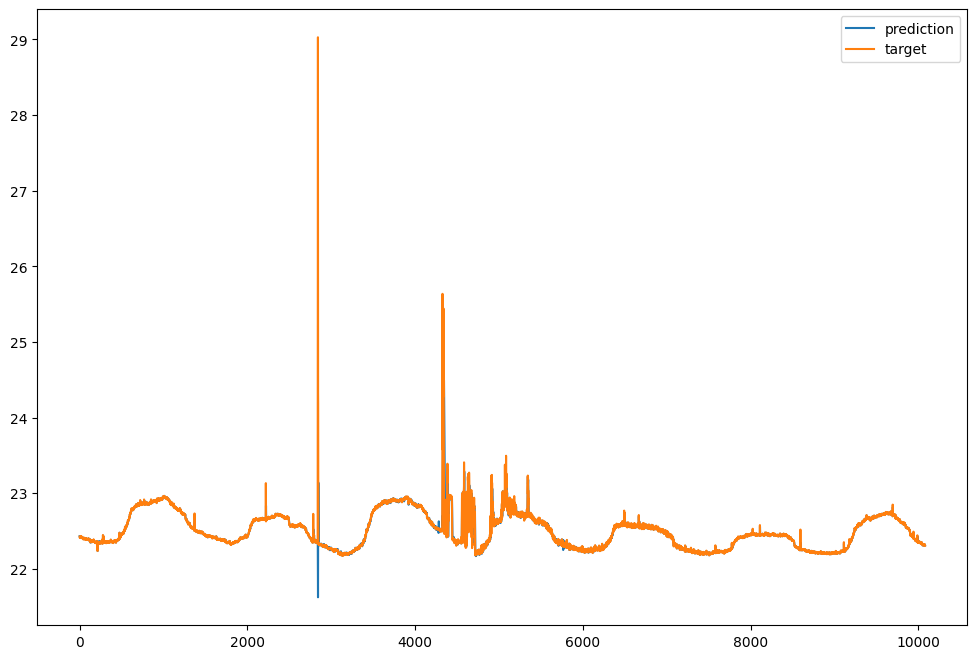

In [47]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [48]:
np.array(pred_list)

array([22.42951012, 22.42441177, 22.41543961, ..., 22.3066864 ,
       22.31537056, 22.3102169 ])

In [49]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

array([[22.423888],
       [22.41452 ],
       [22.416   ],
       ...,
       [22.31816 ],
       [22.31004 ],
       [22.30716 ]])

In [50]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

torch.Size([10080]) torch.Size([10080, 1])


In [51]:
print(SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

0.08972963551059365 %


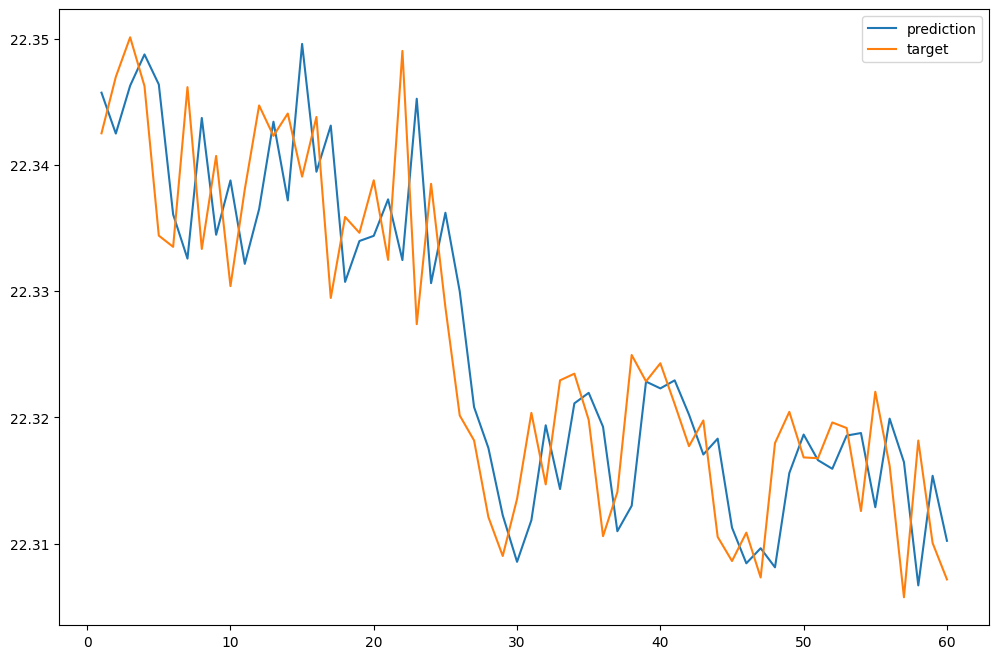

In [52]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [53]:
len(time_list)

10080

In [54]:
np.mean(time_list) 

0.33299960323742456

FIRST

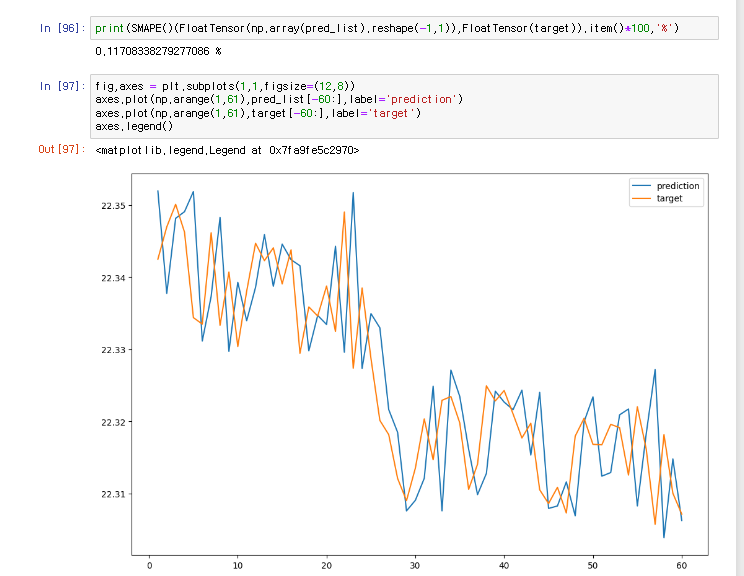